In [1]:
# Librerías principales
from random import randint
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

In [2]:
# Discretización del espacio de observación
def discretizar(valor, env, bins=20):
    valor = np.array(valor)
    escalado = (valor - env.observation_space.low) / (env.observation_space.high - env.observation_space.low)
    discretizado = np.digitize(escalado, np.linspace(0, 1, bins)) - 1
    # Corregir posibles desbordamientos de índice
    discretizado = np.clip(discretizado, 0, bins-1)
    return tuple(discretizado.astype(int))

In [3]:
# Definición de políticas de acción
def policy_epsilon_greedy(q_table, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, q_table.shape[-1])
    else:
        return np.argmax(q_table[state])

def policy_softmax(q_table, state, tau=1.0):
    q_vals = q_table[state]
    exp_q = np.exp((q_vals - np.max(q_vals)) / tau)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_vals), p=probs)

def policy_ucb(q_table, state, counts, t, c=2):
    q_vals = q_table[state]
    ucb_vals = q_vals + c * np.sqrt(np.log(t + 1) / (counts[state] + 1e-5))
    return np.argmax(ucb_vals)

In [4]:
# Celda 4: Configuración inicial
# Ajustes recomendados para mejor aprendizaje
BINS = 40  # Mayor resolución
env = gym.make('MountainCar-v0')
q_table = np.zeros((BINS, BINS, 3))  # Inicializar en ceros
counts = np.ones(q_table.shape, dtype=np.float32)  # Para UCB

params = {
    'tasa_aprendizaje': 0.05,  # Más bajo
    'factor_descuento': 0.99,
    'episodios': 2000,  # Más episodios
    'epsilon_inicial': 1.0,
    'epsilon_min': 0.05,  # No tan bajo
    'decay_rate': 0.995,  # Decaimiento más lento
    'tau': 1.0,  # Softmax
    'c_ucb': 2,   # UCB
    'render_episodios': 50  # Mostrar progreso cada 50 episodios
}

POLICY = 'epsilon_greedy_decay'  # Cambiado para que epsilon decaiga y el agente aprenda

In [5]:
# Celda 5: Entrenamiento con Q-Learning
recompensas = []
estados_visitados = []
epsilon = params['epsilon_inicial']
t = 0  # Contador global para UCB

# Aumentar el número de episodios
params['episodios'] = 2000

# Crear el entorno de render solo una vez para los últimos episodios
render_env = None

for episodio in range(params['episodios']):
    render = episodio >= params['episodios'] - 10  # Renderiza los últimos 5 episodios
    if render:
        if render_env is None:
            render_env = gym.make('MountainCar-v0', render_mode='human')
        env_actual = render_env
    else:
        env_actual = env
    estado = discretizar(env_actual.reset()[0], env_actual)
    done = False
    recompensa_total = 0

    while not done:
        # Selección de acción según la política
        if POLICY == 'epsilon_greedy' or POLICY == 'epsilon_greedy_decay':
            accion = policy_epsilon_greedy(q_table, estado, epsilon)
        elif POLICY == 'softmax':
            accion = policy_softmax(q_table, estado, tau=params['tau'])
        elif POLICY == 'ucb':
            accion = policy_ucb(q_table, estado, counts, t, c=params['c_ucb'])
        else:
            raise ValueError("Política no reconocida")

        # Ejecutar acción
        next_state, reward, terminado, truncado, _ = env_actual.step(accion)
        # Reward shaping: solo bonus al llegar exactamente a la meta
        if next_state[0] >= 0.5:
            reward += 100  # Bonus grande solo si llega a la meta
        done = terminado or truncado
        next_state = discretizar(next_state, env_actual)

        # Actualizar Q-table
        q_table[estado][accion] += params['tasa_aprendizaje'] * (
            reward + params['factor_descuento'] * np.max(q_table[next_state]) - q_table[estado][accion]
        )

        # Actualizar contadores para UCB
        if POLICY == 'ucb':
            counts[estado + (accion,)] += 1

        # Registrar estado visitado
        estados_visitados.append(estado)
        estado = next_state
        recompensa_total += reward
        t += 1

    # Decaimiento de epsilon solo para 'epsilon_greedy_decay'
    if POLICY == 'epsilon_greedy_decay':
        epsilon = max(epsilon * params['decay_rate'], params['epsilon_min'])

    recompensas.append(recompensa_total)

    # Mostrar progreso cada 5 episodios (sin borrar)
    if episodio % 5 == 0 or episodio == params['episodios'] - 1:
        promedio_ultimos_5 = np.mean(recompensas[-5:]) if len(recompensas) >= 5 else np.mean(recompensas)
        print(f"Episodio {episodio} - Recompensa actual: {recompensa_total:.2f} - "
              f"Recompensa promedio últimos 5: {promedio_ultimos_5:.2f} - Epsilon: {epsilon:.3f}")

if render_env is not None:
    render_env.close()
else:
    env.close()

Episodio 0 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.995
Episodio 5 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.970
Episodio 10 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.946
Episodio 15 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.923
Episodio 20 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.900
Episodio 25 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.878
Episodio 30 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.856
Episodio 15 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.923
Episodio 20 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.900
Episodio 25 - Recompensa actual: -200.00 - Recompensa promedio últimos 5: -200.00 - Epsilon: 0.878
Episodio 30 

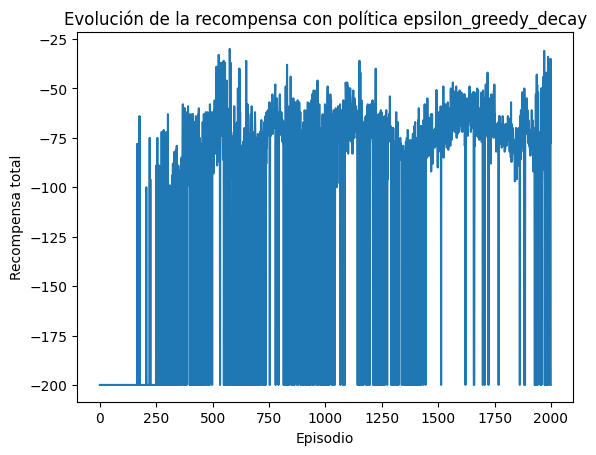

,Posición,Velocidad
0,7,9
1,7,9
2,7,9
3,7,9
4,7,9


Total de estados registrados: 360097


In [35]:
# Celda 6: Visualización de resultados
# Gráfica final de recompensas
plt.plot(recompensas)
plt.xlabel("Episodio")
plt.ylabel("Recompensa total")
plt.title(f"Evolución de la recompensa con política {POLICY}")
plt.show()

# Estados visitados en DataFrame
df_estados = pd.DataFrame(estados_visitados, columns=["Posición", "Velocidad"])
display(df_estados.head())
print(f"Total de estados registrados: {len(df_estados)}")